# **I &nbsp;&nbsp;&nbsp; Import Libraries**

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preprocessor import DataPreprocessor

# **II &nbsp;&nbsp;&nbsp; Load Data**

In [ ]:
train_path = "../../data/input/cleaned/train/train.csv"
test_path = "../../data/input/cleaned/test/test.csv"
val_path = "../../data/input/cleaned/val/val.csv"

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)

## **1 &nbsp;&nbsp;&nbsp; Tokenizer**

In [4]:
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

In [5]:
train_vector = vectorizer.fit_transform(train_df.Text)
test_vector = vectorizer.transform(test_df.Text)
val_vector = vectorizer.transform(val_df.Text)

In [6]:
print(f"Vocab size: {len(vectorizer.vocabulary_)}")

Vocab size: 2000


## **2 &nbsp;&nbsp;&nbsp; Tensorize Data**

In [7]:
X_train = torch.tensor(train_vector.toarray(), dtype=torch.float32)
y_train = torch.tensor(train_df.Label, dtype=torch.long)

X_test = torch.tensor(test_vector.toarray(), dtype=torch.float32)
y_test = torch.tensor(test_df.Label, dtype=torch.long)

X_val = torch.tensor(val_vector.toarray(), dtype=torch.float32)
y_val = torch.tensor(val_df.Label, dtype=torch.long)

# **III &nbsp;&nbsp;&nbsp; MLP Class**

In [8]:
@dataclass
class MLPConfig:
    n_dim: int = len(vectorizer.vocabulary_)
    n_hidden: int = 128
    n_class: int = 3
    dropout: float = 0.3
    
    
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_dim, config.n_hidden),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.n_hidden, config.n_class)
        )
        
        self.apply(self._init_weights)
        print(f"Số lượng tham số: {self.get_num_params() / 1e6:.2f}M")
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def get_num_params(self):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params
            
    def forward(self, x, targets=None):
        logits = self.net(x)
        loss = None if targets is None else F.cross_entropy(logits, targets)
        
        return logits, loss
    
    @torch.no_grad
    def predict(self, text):
        X = vectorizer.transform([text])
        X = torch.tensor(X.toarray(), dtype=torch.float32)
        logits, _ = self(X)
        probs = torch.softmax(logits, dim=-1)
        
        return probs.argmax().item()

# **IV &nbsp;&nbsp;&nbsp; Model**

## **1 &nbsp;&nbsp;&nbsp; Train Model**

In [9]:
model = MLP(MLPConfig())

Số lượng tham số: 0.26M


In [10]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [11]:
batch_size = 128
torch.manual_seed(42)

def get_batch(split):
    data, label = (X_train, y_train) if split == "train" else (X_val, y_val)
    ix = torch.randint(0, len(data), (batch_size, ))
    X = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])
    return X, y

In [12]:
val_iters = 150

@torch.no_grad
def estimate_loss():
    output = {}
    
    model.eval()
    for split in ["train", "val"]:
        data, labels = get_batch(split)
        losses = torch.zeros(val_iters)
        
        for k in range(val_iters):
            _, loss = model(data, labels)
            losses[k] = loss.item()
        
        output[split] = losses.mean()
    model.train()
    
    return output

In [13]:
train_iters = 1500
eval_interval = 150
train_loss, val_loss = [], []
visual_loss = []

for iter in range(train_iters):
    if iter % eval_interval == 0 or iter == train_iters - 1:
        losses = estimate_loss()
        train_loss.append(losses["train"].item())
        val_loss.append(losses["val"].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    X_batch, y_batch = get_batch("train")
    
    optimizer.zero_grad()
    logits, loss = model(X_batch, y_batch)
    visual_loss.append(loss.item())
    loss.backward()
    optimizer.step()

step 0: train loss 1.0986, val loss 1.0982
step 150: train loss 0.5793, val loss 0.5212
step 300: train loss 0.4056, val loss 0.4495
step 450: train loss 0.4071, val loss 0.4181
step 600: train loss 0.3835, val loss 0.4668
step 750: train loss 0.3336, val loss 0.5423
step 900: train loss 0.2982, val loss 0.4474
step 1050: train loss 0.3360, val loss 0.4391
step 1200: train loss 0.2734, val loss 0.4295
step 1350: train loss 0.3194, val loss 0.2930
step 1499: train loss 0.3211, val loss 0.4573


## **2 &nbsp;&nbsp;&nbsp; Evaluate Model**

In [14]:
model.eval()
logits, loss = model(X_test, y_test)
probs = torch.softmax(logits, dim=-1).reshape(-1, 1, 3)
y_pred = probs.argmax(dim=2)
print(f"Test loss: {loss.item()}")

Test loss: 0.4886590242385864


In [29]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8318    0.8687    0.8499      2339
           1     0.8370    0.8206    0.8287      2804
           2     0.6371    0.6038    0.6200       939

    accuracy                         0.8057      6082
   macro avg     0.7686    0.7644    0.7662      6082
weighted avg     0.8041    0.8057    0.8046      6082



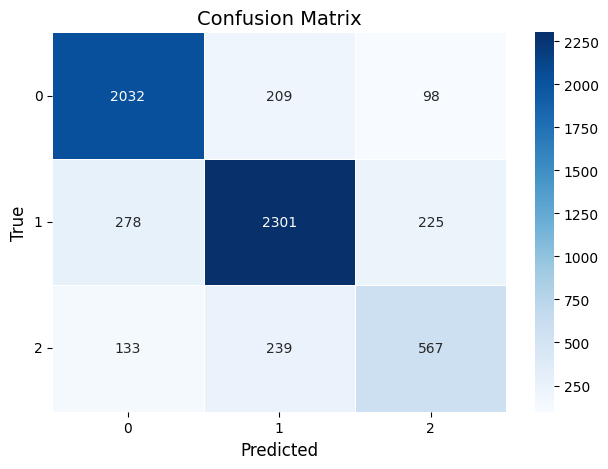

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(ticks=np.arange(3)+0.5, labels=range(3))
plt.yticks(ticks=np.arange(3)+0.5, labels=range(3), rotation=0)

plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("mlp/mlpcm.png", dpi=300, bbox_inches="tight")
plt.show()

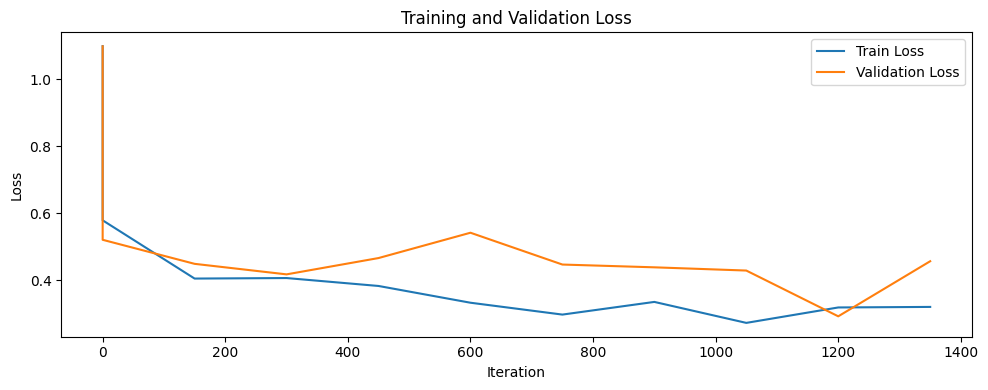

In [ ]:
steps = [0] + list(range(0, train_iters, eval_interval))
plt.figure(figsize=(10, 4))

plt.plot(steps, train_loss, linewidth=1.5, label="Train Loss")
plt.plot(steps, val_loss, linewidth=1.5, label="Validation Loss")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("mlp/mlptrainvalloss.png", dpi=300, bbox_inches="tight")
plt.show()

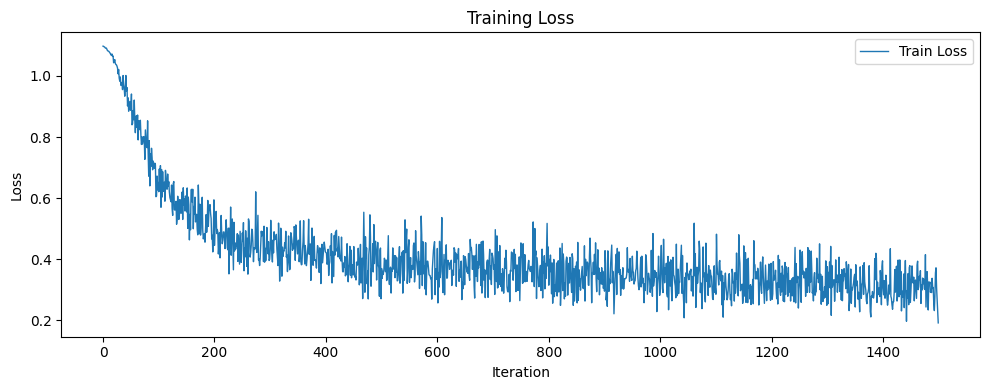

In [ ]:
steps = list(range(0, train_iters))
plt.figure(figsize=(10, 4))

plt.plot(steps, visual_loss, linewidth=1, label="Train Loss",)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.tight_layout()
plt.savefig("mlp/mlptrainloss.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
preprocessor = DataPreprocessor()
model.predict(preprocessor.preprocess("Sản phẩm rất tệ"))

0

In [21]:
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=2000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


## **3 &nbsp;&nbsp;&nbsp; Save Model**

In [ ]:
torch.save(model.state_dict(), "mlp/mlp.pth")